<a href="https://colab.research.google.com/github/dfn-ads/Big-Data-Analysis/blob/main/ML_cifar_CNN_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


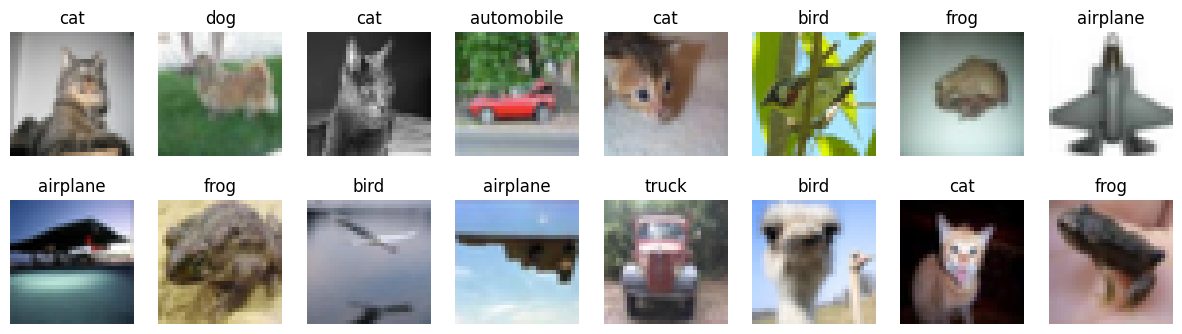

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

One-hot encoding assigns a binary expression for each class, making access easier for the CNN.


In [5]:
# normalize inputs
# normalization has been done in cell 1 when the arrays are defined
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_val = keras.utils.to_categorical(y_val, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)



In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, LeakyReLU, GlobalMaxPooling2D
from tensorflow import image, data

The following code block was an attempt at data augmentation using TensorFlow since the equivalant Keras functions were disencouraged in the documentation. Since this tensor object is different from the training data set, it caused complications for the integration of newly generated images into the original training data set.

In [7]:
'''def augment(image_label, seed): # Function to generate new image from the existing data set
  image, label = image_label # Separate the image and the label as different variables
  image = tf.convert_to_tensor(image) # Convert the image input into Tensor class object
  image = tf.image.convert_image_dtype(image, tf.float32) # Express the tensor values as 32-bit floats
  seed = tf.cast(seed, tf.int32) # Generate seeds to keep track of the random operations
  # Flip horizontally randomly
  image=tf.image.stateless_random_flip_left_right(image, seed)
  # Increase saturation randomly
  image=tf.image.stateless_random_saturation(image, 1, 2, seed)
  return image, label


AUTOTUNE = tf.data.AUTOTUNE
# Convert x_train (NumPy array) to a TensorFlow Dataset
x_train_ds = tf.data.Dataset.from_tensor_slices(x_train)

# Create a "counter" object
counter = tf.data.experimental.Counter()

# Convert training sets to TensorFlow data sets
x_train_ds = tf.data.Dataset.zip((x_train_ds, (counter, counter)))
y_train_ds = tf.data.Dataset.from_tensor_slices(y_train)

train_ds = tf.data.Dataset.zip(((x_train_ds, y_train_ds), (counter, counter)))

train_ds = train_ds.map(augment)

# Shuffle and batch the dataset
BATCH_SIZE = 32
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)'''



'def augment(image_label, seed): # Function to generate new image from the existing data set\n  image, label = image_label # Separate the image and the label as different variables\n  image = tf.convert_to_tensor(image) # Convert the image input into Tensor class object\n  image = tf.image.convert_image_dtype(image, tf.float32) # Express the tensor values as 32-bit floats\n  seed = tf.cast(seed, tf.int32) # Generate seeds to keep track of the random operations\n  # Flip horizontally randomly\n  image=tf.image.stateless_random_flip_left_right(image, seed)\n  # Increase saturation randomly\n  image=tf.image.stateless_random_saturation(image, 1, 2, seed)\n  return image, label\n\n\nAUTOTUNE = tf.data.AUTOTUNE\n# Convert x_train (NumPy array) to a TensorFlow Dataset\nx_train_ds = tf.data.Dataset.from_tensor_slices(x_train)\n\n# Create a "counter" object\ncounter = tf.data.experimental.Counter()\n\n# Convert training sets to TensorFlow data sets\nx_train_ds = tf.data.Dataset.zip((x_train_ds

All CNN models consist of same layer components arranged in various formats, yet small adjustments like the type of activation function used, the number of filters in convolution layers, or the inclusion of drop-out layers contribute to the accuracy of the model. The model built here was inspired by MSP students Jude and Smrithi's models, as well as various web pages on improving the accuracy of a CNN.

The filter (kernel) number is increased for each convolutional layer, and Leaky ReLU is found to provide more accuracy compared to regular ReLU as an activation function. The kernel size is set to the minimum dimensions (3x3) for the least amount of information loss. The same is true for pooling layers with the pool size set to 2x2.

Although it's unclear how exactly batch normalization improves the CNN, it allows for more effective optimization and better generalization (https://arxiv.org/pdf/1805.11604). This technique was used after each convolutional and pooling layer for a smoother CNN.

In [8]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential() # Define a model where each layer takes one input tensor and returns one output tensor

    ### STUDENT CODE HERE ###

    ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
    ### Then, add a Pooling layer to pick up the relevant kernels.
    ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
    ### to learn the relevant combinations of low-level kernel features.
    ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima.
    ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.
    ### END STUDENT CODE ###

    # First Convolutional Layer
    model.add(Conv2D(32, kernel_size=(3, 3), padding = "same", activation="leaky_relu", input_shape=(32, 32, 3)))  # 32x32 RGB image (32x32 pixels, 3 channels)
    model.add(Conv2D(32, kernel_size=(3, 3), padding = "same", activation="leaky_relu")) # The padding is set to same to keep the tensor size the same as the original
    model.add(BatchNormalization()) # Normalize the output for a smoother run
    model.add(MaxPooling2D(pool_size=(2, 2))) # Pooling layer to reduce spatial size
    model.add(BatchNormalization())

    # The same structure is repeated to build a more powerful model

    # Second Convolutional Layer
    model.add(Conv2D(64, kernel_size=(3, 3), padding = "same", activation="leaky_relu"))
    model.add(Conv2D(64, kernel_size=(3, 3), padding = "same", activation="leaky_relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Third Convolutional Layer
    model.add(Conv2D(128, kernel_size=(3, 3), padding = "same", activation="leaky_relu"))
    model.add(Conv2D(128, kernel_size=(3, 3), padding = "same", activation="leaky_relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Fourth Convolutional Layer
    model.add(Conv2D(256, kernel_size=(3, 3), padding = "same", activation="leaky_relu"))
    model.add(Conv2D(256, kernel_size=(3, 3), padding = "same", activation="leaky_relu"))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling2D(keepdims=True)) # Use GlobalMaxPooling2D instead of MaxPooling2D
    # This collapses the tensor into a single value
    # Using this method for the later layers allows for the most prominent feature get picked up
    model.add(BatchNormalization())

    # Turn the output tensor into a one-dimensional vector
    model.add(Flatten())

    # Fully Connected Layers
    # idea for adding multiple dense layers taken from Jude
    model.add(Dense(256)) # Start with a 256-entry tensor for the first dense layer to extract details
    model.add(Dropout(0.5)) # Dropout sets some entries of the output to zero in order to avoid overfitting
    # The dropout probability is set to 0.5 for this step
    model.add(LeakyReLU(alpha=0.01)) # The activation function for the dense layer
    #Leaky ReLU requires this to be added as a separate line
    model.add(BatchNormalization())

    model.add(Dense(128)) # Create a smaller second dense layer to pick up prominent features
    model.add(Dropout(0.4)) # Set a lower dropout probability to retain more information
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())


    # Obtain the output layer with 10 neurons (for 10 classes)
    model.add(Dense(10)) # Reducing the size to ten makes the model focus on the categorization of images
    model.add(Dropout(0.3)) # One more dropout layer with lower probability
    model.add(Activation("softmax")) # Final layer activation, Softmax is used for multi-class single label classification

    return model

In order to increase model accuracy, Adam Optimizer was preferred as this algorithm adapts the learning rate for each parameter separately, while also being memory-efficient (https://www.geeksforgeeks.org/adam-optimizer/).

Since the model we're working with uses multi-class single label data, the loss function to be used is "categorical cross entropy". This function allows for the model to determine how far away from the actual value its guess is.

In [9]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 5e-4  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 30 # This takes about 8 minutes with Google Collab's GPU

opt= keras.optimizers.Adam(learning_rate=INIT_LR)
# Adam alters the learning rate when the accuracy of the model is stagnant

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=opt,  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)
# The callback makes the model decrease the learning rate when the "value loss" plateaus
# if the parameter doesn't change for 4 rounds, the learning rate is reduced to 1/5 of the value
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

# fit model
model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[callback], # use the defined callback here
    shuffle=True, # shuffles the training data set so that the order of training images will not affect the model
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.2148 - loss: 2.5014 - val_accuracy: 0.4108 - val_loss: 1.6204 - learning_rate: 5.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.4066 - loss: 1.6812 - val_accuracy: 0.5435 - val_loss: 1.2467 - learning_rate: 5.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5014 - loss: 1.3996 - val_accuracy: 0.6612 - val_loss: 0.9988 - learning_rate: 5.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5487 - loss: 1.2496 - val_accuracy: 0.6886 - val_loss: 0.9161 - learning_rate: 5.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5871 - loss: 1.1372 - val_accuracy: 0.7299 - val_loss: 0.8132 - learning_rate: 5.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6148 - loss: 1.0507 - val_accuracy: 0.7418 - val_loss: 0.8241 - learning_rate: 5.0000e-04
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


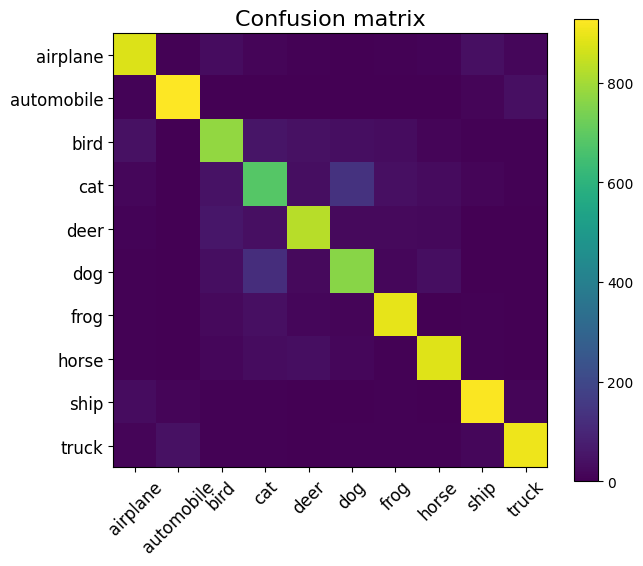

Test accuracy: 0.8452


In [10]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

In 30 epochs, the test accuracy has gone up to 84.5%. With unlimited access to a GPU this model could be trained for longer, until the callback line stops the code.
The confusion matrix shows that most predictions are accurate, with the model struggling more with identifying birds, dogs, and cats compared to other classes.

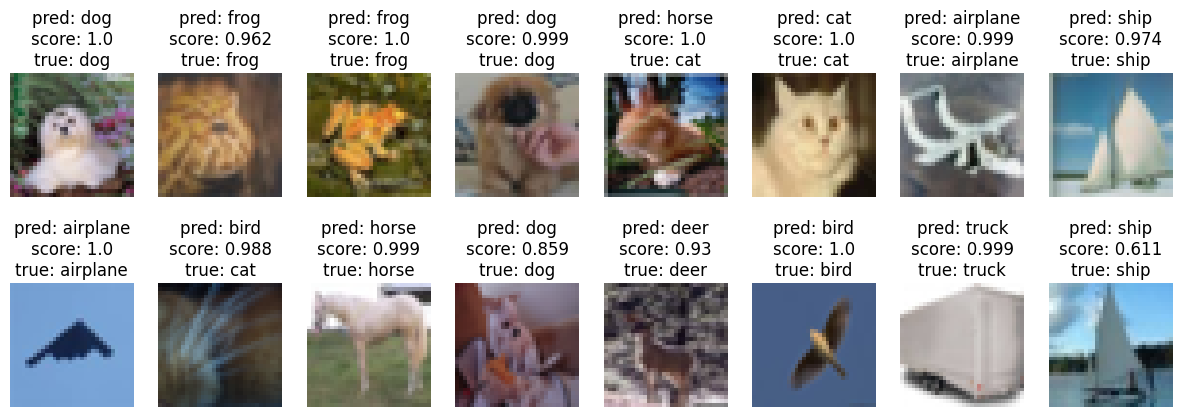

In [11]:
# inspect predictions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

The output above shows that the model is usually very accurate and confident in its guesses. The confidency doesn't always match with the accuracy of the guess, as can be seen from the cat that was mistaken for a horse and the ship guess that was only 61% confident despite being true. While the latter might be improved with further training, the confusion matrix showed that cats were particularly difficult to identify.

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


